In [1]:
import numpy as np
import matplotlib
import pandas as pd

import os
import pwd
import sys
from matplotlib import pyplot as plt
import pymc3 as pm

import seaborn as sns
sns.set_context('poster')
sns.set_palette('colorblind')

Text(0, 0.5, 'Relative probability')

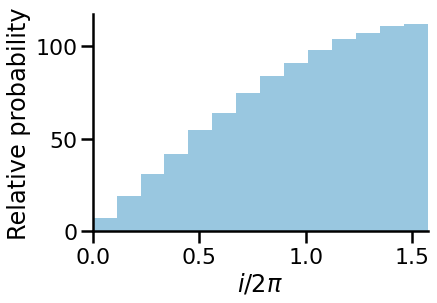

In [2]:
i = np.linspace(0, np.pi/2, 100)
cosi = np.linspace(0, 1, 1000)
i = np.arccos(cosi)
sns.distplot(i, kde=False)
sns.despine()
plt.xlim(0, np.pi/2)
plt.xlabel(f'$i/2\pi$')
plt.ylabel(f'Relative probability')

In [3]:
bro = pd.read_csv('../data/bronze.csv', index_col=0)
ati = pd.read_csv('../data/atium.csv', index_col=0)
cad = pd.read_csv('../data/cadmium.csv', index_col=0)

kic = ati.sample(1).KIC.values[0]
# kic = 12069424
print(kic)

freqs = bro[bro.KIC == str(kic)]
param = ati[ati.KIC == int(kic)]
param['alpha'] = cad[cad.KIC == int(kic)].alpha.values[0]
deltanu = param.dnu.values


9139151


<ipython-input-3-f7cd92c3c9d9>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  param['alpha'] = cad[cad.KIC == int(kic)].alpha.values[0]


In [4]:
freqs.columns
param.columns

Index(['KIC', 'Teff', 'age', 'dnu', 'eTeff', 'ednu', 'efeh', 'enumax', 'feh',
       'loage', 'lomodlogg', 'lomodmass', 'lomodrad', 'modlogg', 'modmass',
       'modrad', 'numax', 'source', 'upage', 'upmodlogg', 'upmodmass',
       'upmodrad', 'G', 'bprp', 'hrclass', 'neff_xsplit', 'neff_cosi',
       'neff_split', 'neff_i', 'l_nus*', 'nus*', 'u_nus*', 'l_cosi', 'cosi',
       'u_cosi', 'l_nus', 'nus', 'u_nus', 'l_i', 'i', 'u_i', 'fit_numax',
       'efit_numax', 'fit_d01', 'efit_d01', 'fit_d02', 'efit_d02',
       'fit_epsilon', 'efit_epsilon', 'V1', 'eV1', 'V2', 'eV2', 'l_P', 'P',
       'u_P', 'l_vsini', 'vsini', 'u_vsini', 'rhat_flag', 'eye_flag', 'ebprp',
       'alpha'],
      dtype='object')

In [5]:
class model():
    def __init__(self, f, n0_, n1_, n2_, deltanu_):
        self.f = f
        self.n0 = n0_
        self.n1 = n1_
        self.n2 = n2_
        self.npts = len(f)
        self.M = [len(n0_), len(n1_), len(n2_)]
        self.deltanu = deltanu_
                
    def lor(self, freq, h, w):
        return h / (1.0 + 4.0/tt.sqr(w)*tt.sqr((self.f - freq)))

    def mode(self, l, freqs, hs, ws, i, split=0):
        for idx in range(self.M[l]):
            for m in range(-l, l+1, 1):
                self.modes += self.lor(freqs[idx] + (m*split),
                                     hs[idx] * self.epsilon(i, l, abs(m)),
                                     ws[idx])
    # Small separations are fractional
    def asymptotic(self, n, numax, alpha, epsilon, d=0.):
        nmax = (numax / self.deltanu) - epsilon
        curve = (alpha/2.)*(n-nmax)*(n-nmax)
        return (n + epsilon + d + curve) * self.deltanu

    def f0(self, p):
        numax, alpha, epsilon, d01, d02 = p

        return self.asymptotic(self.n0, numax, alpha, epsilon, 0.)

    def f1(self, p):
        numax, alpha, epsilon, d01, d02 = p

        return self.asymptotic(self.n1, numax, alpha, epsilon, d01)

    def f2(self, p):
        numax, alpha, epsilon, d01, d02 = p

        return self.asymptotic(self.n2+1, numax, alpha, epsilon, -d02)
    
    def A0(self, f, p, theano=True):
        numax, w, A, V1, V2 = p
        height = self.gaussian(f, numax, w, A)
        if theano:
            return height
        else:
            return height.eval()

    def A1(self, f, p, theano=True):
        numax, w, A, V1, V2 = p
        height = self.gaussian(f, numax, w, A)*V1
        if theano:
            return height
        else:
            return height.eval()

    def A2(self, f, p, theano=True):
        numax, w, A, V1, V2 = p
        height = self.gaussian(f, numax, w, A)*V2
        if theano:
            return height
        else:
            return height.eval()
    
    def gaussian(self, freq, numax, w, A):
        return A * np.exp(-0.5 * ((freq - numax)**2) / w**2)

In [6]:
ls = [freqs[freqs.l == ell].f.values for ell in [0, 1, 2]]
els = [freqs[freqs.l == ell].f_e.values for ell in [0, 1, 2]]
ns = [freqs[freqs.l == ell].n.values for ell in [0, 1, 2]]
res = [param[label].values[0] for label in ['fit_numax', 'alpha', 'fit_epsilon','fit_d01','fit_d02']]

In [7]:
f = np.linspace(freqs.f.min() - 0.25*deltanu, freqs.f.max() + 0.25*deltanu, 1000)
mod = model(f, ns[0], ns[1], ns[2], deltanu)

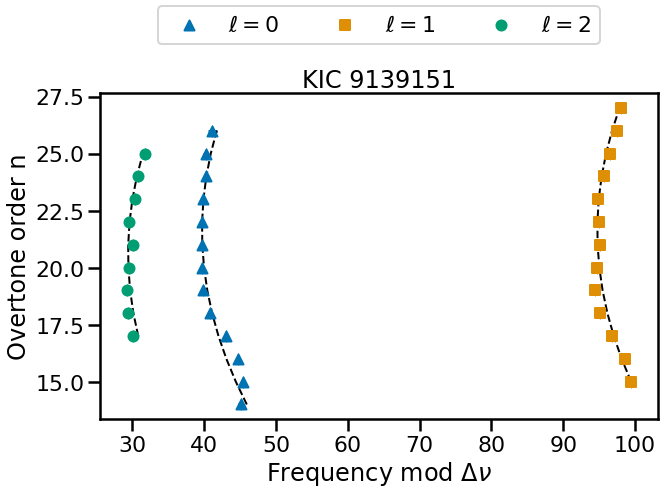

In [8]:
fig, ax = plt.subplots(figsize=(10,6))



ax.scatter(ls[0]%deltanu, ns[0], marker='^',label=r'$\ell = 0$', s=100, zorder=3)
ax.scatter(ls[1]%deltanu, ns[1], marker=',',label=r'$\ell = 1$', s=100, zorder=3)
ax.scatter(ls[2]%deltanu, ns[2], marker='o',label=r'$\ell = 2$', s=100, zorder=3)
ax.errorbar(ls[0]%deltanu, ns[0], xerr = els[0], yerr = 0, fmt='|', zorder=1)
ax.errorbar(ls[1]%deltanu, ns[1], xerr = els[1], yerr = 0, fmt='|', zorder=1)
ax.errorbar(ls[2]%deltanu, ns[2], xerr = els[2], yerr = 0, fmt='|', zorder=1)

ax.plot(mod.f0(res)%deltanu, mod.n0, lw=2, zorder=1, c='k', ls='--')
ax.plot(mod.f1(res)%deltanu, mod.n1, lw=2, zorder=1, c='k', ls='--')
ax.plot(mod.f2(res)%deltanu, mod.n2, lw=2, zorder=1, c='k', ls='--')

ax.set_xlabel(r'Frequency mod $\Delta\nu$')
ax.set_ylabel('Overtone order n')
ax.set_title(f'KIC {kic}')
ax.legend(loc='upper center', ncol=4, bbox_to_anchor=(0.5, 1.3))
plt.savefig("glitches.png", dpi=300,  bbox_inches = "tight")
plt.show()

In [9]:
fs = [freqs[freqs.l == ell].f.values for ell in [0, 1, 2]]
efs = [freqs[freqs.l == ell].f_e.values for ell in [0, 1, 2]]
As = [freqs[freqs.l == ell].A.values for ell in [0, 1, 2]]
eAs = [freqs[freqs.l == ell].A_e.values for ell in [0, 1, 2]]

In [10]:
param['w'] = (0.25*param.fit_numax)/1.5
param['A'] = np.nanmax(As[1])*0.8

<ipython-input-10-18a5843b9523>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  param['w'] = (0.25*param.fit_numax)/1.5
<ipython-input-10-18a5843b9523>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  param['A'] = np.nanmax(As[1])*0.8


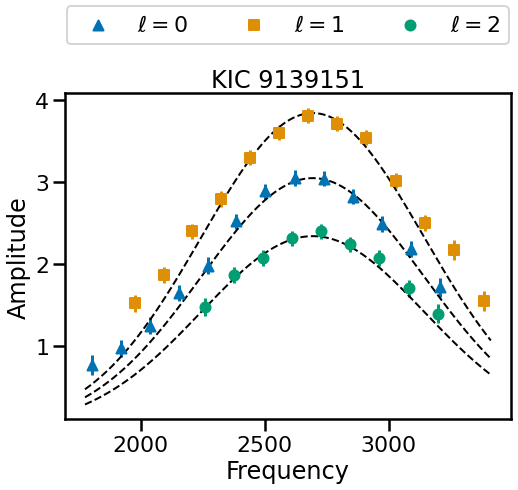

In [11]:
res = [param[label].values[0] for label in ['fit_numax', 'w', 'A','V1','V2']]

fig, ax = plt.subplots(figsize=(8,6))

ax.scatter(ls[0], As[0], marker='^',label=r'$\ell = 0$', s=100, zorder=3)
ax.scatter(ls[1], As[1], marker=',',label=r'$\ell = 1$', s=100, zorder=3)
ax.scatter(ls[2], As[2], marker='o',label=r'$\ell = 2$', s=100, zorder=3)
ax.errorbar(ls[0], As[0], xerr = efs[0], yerr = eAs[0], fmt='|', zorder=1)
ax.errorbar(ls[1], As[1], xerr = efs[1], yerr = eAs[1], fmt='|', zorder=1)
ax.errorbar(ls[2], As[2], xerr = efs[2], yerr = eAs[2], fmt='|', zorder=1)

ax.plot(f, mod.A0(f, res), lw=2, zorder=1, c='k', ls='--')
ax.plot(f, mod.A1(f, res), lw=2, zorder=1, c='k', ls='--')
ax.plot(f, mod.A2(f, res), lw=2, zorder=1, c='k', ls='--')

ax.set_xlabel(r'Frequency')
ax.set_ylabel('Amplitude')
ax.set_title(f'KIC {kic}')
ax.legend(loc='upper center', ncol=4, bbox_to_anchor=(0.5, 1.3))
plt.savefig("amplitudes.png", dpi=300,  bbox_inches = "tight")
plt.show()

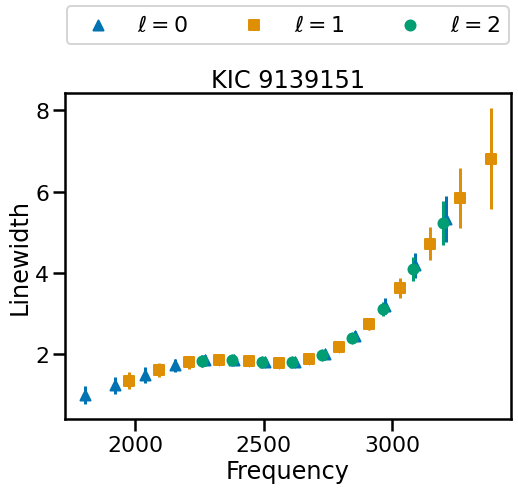

In [13]:
fs = [freqs[freqs.l == ell].f.values for ell in [0, 1, 2]]
efs = [freqs[freqs.l == ell].f_e.values for ell in [0, 1, 2]]
Ls = [freqs[freqs.l == ell].g.values for ell in [0, 1, 2]]
eLs = [freqs[freqs.l == ell].g_e.values for ell in [0, 1, 2]]

fig, ax = plt.subplots(figsize=(8,6))

ax.scatter(ls[0]-.1, Ls[0], marker='^',label=r'$\ell = 0$', s=100, zorder=3)
ax.scatter(ls[1], Ls[1], marker=',',label=r'$\ell = 1$', s=100, zorder=3)
ax.scatter(ls[2]+.1, Ls[2], marker='o',label=r'$\ell = 2$', s=100, zorder=3)
ax.errorbar(ls[0]-.1, Ls[0], xerr = efs[0], yerr = eLs[0], fmt='|', zorder=1)
ax.errorbar(ls[1], Ls[1], xerr = efs[1], yerr = eLs[1], fmt='|', zorder=1)
ax.errorbar(ls[2]+.1, Ls[2], xerr = efs[2], yerr = eLs[2], fmt='|', zorder=1)

ax.set_xlabel(r'Frequency')
ax.set_ylabel('Linewidth')
ax.set_title(f'KIC {kic}')
ax.legend(loc='upper center', ncol=4, bbox_to_anchor=(0.5, 1.3))
plt.savefig("linewidths.png", dpi=300,  bbox_inches = "tight")
plt.show()